In [1]:
%matplotlib inline

In [2]:
def apply_plot_params(font_size=20, width_pt=1000, aspect_ratio=1, height_cm=None, width_cm=None):
    """
    aspect_ratio = height / (width * golden_mean)
    """
    import pylab
    import math

    if width_pt is not None and width_cm is None:
        inches_per_pt = 1.0 / 72.27  # Convert pt to inch
        golden_mean = (math.sqrt(5.0) - 1.0) / 2.0  # Aesthetic ratio
        fig_width = width_pt * inches_per_pt  # width in inches
        fig_height = fig_width * golden_mean  # height in inches
        fig_size = [fig_width, aspect_ratio * fig_height]
    else:
        inches_per_cm = 1.0 / 2.54
        width_cm = 16.0 if width_cm is None else width_cm
        height_cm = 23.0 if height_cm is None else height_cm
        fig_size = [width_cm * inches_per_cm, height_cm * inches_per_cm]

    params = {
        'axes.labelsize': font_size,
        'font.size': font_size,
        'legend.fontsize': font_size,
        'xtick.labelsize': font_size,
        'ytick.labelsize': font_size,
        'figure.figsize': fig_size,
        "axes.titlesize": font_size
    }

    pylab.rcParams.update(params)


In [13]:
# get data
import numpy as np
from collections import OrderedDict
import pandas as pd
from datetime import datetime, timedelta
from matplotlib.dates import date2num, num2date



data_yearly = OrderedDict()
skiprows = 2
data_yearly["1_yeardryAB"] = pd.read_csv("simulation_1_yeardryAB.txt", skiprows=skiprows, sep="\s+", header=None)
data_yearly["1_yearsatAB"] = pd.read_csv("simulation_1_yearsatAB.txt", skiprows=skiprows, sep="\s+", header=None)



In [4]:
data_yearly["1_yeardryAB"].describe()

,0,1,2,3,4
count,365.000000,365.000000,365.000000,365.000000,365.000000
mean,183.000000,41.919315,22.136629,36.936164,20.676539
std,105.510663,54.423157,48.792338,38.511702,48.286932
min,1.000000,5.920000,0.000000,8.000000,0.000000
25%,92.000000,10.090000,0.000222,9.600000,0.000222
50%,183.000000,15.010000,4.543493,17.600000,4.146693
75%,274.000000,55.459999,16.190815,49.900002,14.830003
max,365.000000,421.630005,306.286682,155.199997,306.286682


In [5]:

d0 = datetime(2013, 1, 1)
dates = [d0 + timedelta(days=nd-1) for nd in data_yearly["1_yeardryAB"][0]]

dry1yearAB = data_yearly["1_yeardryAB"]
dry1yearAB["date"] = dates
dry1yearAB.set_index("date", inplace=True)


In [6]:
dry1yearAB.describe()

,0,1,2,3,4
count,365.000000,365.000000,365.000000,365.000000,365.000000
mean,183.000000,41.919315,22.136629,36.936164,20.676539
std,105.510663,54.423157,48.792338,38.511702,48.286932
min,1.000000,5.920000,0.000000,8.000000,0.000000
25%,92.000000,10.090000,0.000222,9.600000,0.000222
50%,183.000000,15.010000,4.543493,17.600000,4.146693
75%,274.000000,55.459999,16.190815,49.900002,14.830003
max,365.000000,421.630005,306.286682,155.199997,306.286682


In [52]:
from matplotlib.transforms import Bbox, TransformedBbox, \
     blended_transform_factory

from mpl_toolkits.axes_grid1.inset_locator import BboxPatch, BboxConnector,\
     BboxConnectorPatch
    


def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = prop_lines.copy()
        prop_patches["alpha"] = prop_patches.get("alpha", 1)*0.2

    c1 = BboxConnector(bbox1, bbox2, loc1=loc1a, loc2=loc2a, **prop_lines)
    c1.set_clip_on(False)
    c2 = BboxConnector(bbox1, bbox2, loc1=loc1b, loc2=loc2b, **prop_lines)
    c2.set_clip_on(False)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(bbox1, bbox2,
                           #loc1a=3, loc2a=2, loc1b=4, loc2b=1,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           **prop_patches)
    p.set_clip_on(False)

    return c1, c2, bbox_patch1, bbox_patch2, p


def zoom_effect01(ax1, ax2, xmin, xmax, **kwargs):
    """
    ax1 : the main axes
    ax1 : the zoomed axes
    (xmin,xmax) : the limits of the colored area in both plot axes.

    connect ax1 & ax2. The x-range of (xmin, xmax) in both axes will
    be marked.  The keywords parameters will be used ti create
    patches.

    """

    trans1 = blended_transform_factory(ax1.transData, ax1.transAxes)
    trans2 = blended_transform_factory(ax2.transData, ax2.transAxes)

    bbox = Bbox.from_extents(xmin, 0, xmax, 1)

    mybbox1 = TransformedBbox(bbox, trans1)
    mybbox2 = TransformedBbox(bbox, trans2)

    prop_patches=kwargs.copy()
    prop_patches["ec"]="none"
    prop_patches["alpha"]=0.2

    c1, c2, bbox_patch1, bbox_patch2, p = \
        connect_bbox(mybbox1, mybbox2,
                     loc1a=3, loc2a=2, loc1b=4, loc2b=1,
                     prop_lines=kwargs, prop_patches=prop_patches)

    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p


def zoom_effect02(ax1, ax2, **kwargs):
    """
    ax1 : the main axes
    ax1 : the zoomed axes

    Similar to zoom_effect01.  The xmin & xmax will be taken from the
    ax1.viewLim.
    """

    tt = ax1.transScale + (ax1.transLimits + ax2.transAxes)
    trans = blended_transform_factory(ax2.transData, tt)

    mybbox1 = ax1.bbox
    mybbox2 = TransformedBbox(ax1.viewLim, trans)

    prop_patches=kwargs.copy()
    prop_patches["ec"]="none"
    prop_patches["alpha"]=0.2

    c1, c2, bbox_patch1, bbox_patch2, p = \
        connect_bbox(mybbox1, mybbox2,
                     loc1a=3, loc2a=2, loc1b=4, loc2b=1,
                     prop_lines=kwargs, prop_patches=prop_patches)

    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    #ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p


(15706.0, 16070.0)
(15871.0, 15885.0)


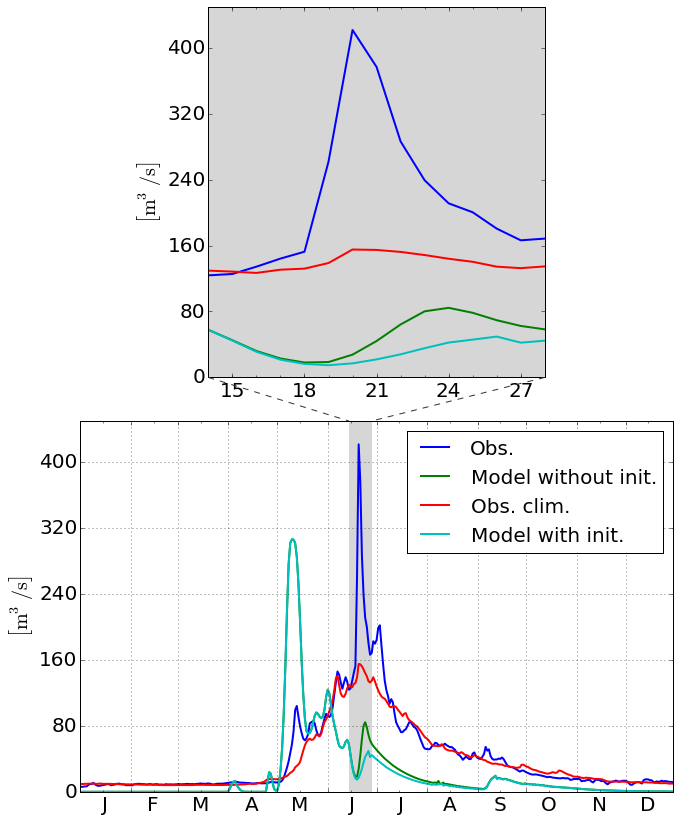

In [61]:
# entry point
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator
from matplotlib.dates import MonthLocator
from matplotlib.dates import DayLocator


gs = GridSpec(2, 3, width_ratios=[0.1, 1, 0.1])
apply_plot_params(width_cm=25, height_cm=30)
fig = plt.figure()
ax1 = fig.add_subplot(gs[0, 1])
ax2 = plt.subplot(gs[1, :])
# ax2.set_xlim(0, 1)
# ax2.set_xlim(0, 5)




dry1yearAB.plot(x=dry1yearAB.index, y=list(range(1, dry1yearAB.shape[1])), linewidth=2, ax=ax2, legend=False)
dry1yearAB.plot(x=dry1yearAB.index, y=list(range(1, dry1yearAB.shape[1])), linewidth=2, ax=ax1, legend=False)

zoom_start = datetime(2013, 6, 15)
zoom_end = datetime(2013, 6, 29)

ax1.set_xlim(zoom_start, zoom_end)
print(ax2.get_xlim())
print(ax1.get_xlim())

zoom_effect02(ax1, ax2, linestyle="dashed", color="0.2")

# format axes
ax1.set_ylabel(ylabel=r"$\left[{\rm m^3/s} \right]$")
ax1.set_xlabel("")
ax1.yaxis.set_major_locator(MaxNLocator(nbins=6))
ax1.xaxis.set_major_formatter(FuncFormatter(lambda d, pos: num2date(d).strftime("%d")))
ax1.xaxis.set_minor_formatter(FuncFormatter(lambda d, pos: num2date(d).strftime("")))
ax1.xaxis.set_major_locator(DayLocator(interval=3))


ax2.set_ylabel(ylabel=r"$\left[{\rm m^3/s} \right]$")
ax2.set_xlabel("")
ax2.xaxis.set_minor_formatter(FuncFormatter(lambda d, pos: num2date(d).strftime("%b")[0]))
ax2.xaxis.set_major_formatter(FuncFormatter(lambda d, pos: ""))
ax2.xaxis.set_major_locator(MonthLocator(bymonthday=1))
ax2.xaxis.set_minor_locator(MonthLocator(bymonthday=15))
ax2.yaxis.set_major_locator(MaxNLocator(nbins=6))
ax2.grid()
ax2.legend(["Obs.", "Model without init.", "Obs. clim.", "Model with init."])


gs.tight_layout(fig)

fig.savefig("hydrographs.png", bbox_inches="tight")
